In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from os import listdir
from scipy.signal import medfilt
#from tqdm import tqdm
from scipy.io import loadmat

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
import keras
from utils import *

from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

# Define the data folder location

data_dir ='a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0'.encode()

dir='a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0/experiment-i/'

Fr = [] #Frames_label
S = [] #Subjct_label
P = [] # Position_label

Fr, S,P = get_datasets(data_dir,dir)

x_frames = np.array(Fr).astype(np.int)
y_subject = np.array(S).astype(np.int)
y_posture = np.array(P).astype(np.int)

#apply filter
x_frames = filter(x_frames)

#delete same frames with too few data
x_frames,y_subject,y_posture = remove(x_frames,y_subject,y_posture)


def split(x_frames, y_subject, y_posture):
    X_train, X_test, y_train_sub, y_test_sub, y_train_pos, y_test_pos = train_test_split(x_frames, y_subject,y_posture,test_size=0.25, random_state=42)

    X_train, X_val, y_train_sub, y_val_sub, y_train_pos, y_val_pos = train_test_split(X_train, y_train_sub, y_train_pos, test_size=0.25, random_state=42)

    x_train = np.array(X_train).astype(np.int)
    x_val = np.array(X_val).astype(np.int)
    x_test = np.array(X_test).astype(np.int)

    y_train_sub = np.array(y_train_sub).astype(np.int)
    y_val_sub = np.array(y_val_sub).astype(np.int)
    y_test_sub = np.array(y_test_sub).astype(np.int)

    y_train_pos = np.array(y_train_pos).astype(np.int)
    y_val_pos = np.array(y_val_pos).astype(np.int)
    y_test_pos = np.array(y_test_pos).astype(np.int)

    print("x_train shape: " + str(x_train.shape))
    print("x_test shape: " + str(x_test.shape))
    print("x_valid shape: " + str(x_val.shape))

    print("y_train_sub shape: " + str(y_train_sub.shape))
    print("y_test_sub shape: " + str(y_test_sub.shape))
    print("y_valid _subshape: " + str(y_val_sub.shape))

    print("y_train_pos shape: " + str(y_train_pos.shape))
    print("y_test_pos shape: " + str(y_test_pos.shape))
    print("y_valid _pos shape: " + str(y_val_pos.shape))

    return x_train, x_test, x_val, y_train_sub, y_test_sub, y_val_sub, y_train_pos, y_test_pos, y_val_pos

#split
x_train, x_test, x_val, y_train_sub, y_test_sub, y_val_sub, y_train_pos, y_test_pos, y_val_pos = split(x_frames,y_subject,y_posture)

#normalization
x_train, x_val, x_test = normalization(x_train,x_val,x_test)

#reshape to n,64,32
x_train, x_val, x_test = reshape(x_train,x_val,x_test)

#apply one hot encode
y_train_sub,y_test_sub,y_val_sub,y_train_pos,y_test_pos,y_val_pos = hot_encode(y_train_sub,y_test_sub,y_val_sub,y_train_pos,y_test_pos,y_val_pos)


x_train shape: (11253, 2048)
x_test shape: (5002, 2048)
x_valid shape: (3751, 2048)
y_train_sub shape: (11253,)
y_test_sub shape: (5002,)
y_valid _subshape: (3751,)
y_train_pos shape: (11253,)
y_test_pos shape: (5002,)
y_valid _pos shape: (3751,)
x_train_n1 (11253, 64, 32, 1)
x_test_n1 (5002, 64, 32, 1)
x_valid_n1 (3751, 64, 32, 1)
(11253, 14)
(5002, 14)
(3751, 14)
(11253, 4)
(5002, 4)
(3751, 4)


# Subject identification

In [ ]:
def model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub):


    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=14, activation='softmax', name='subject')(x)

    model = Model(inputs=x_input, outputs=[output1])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    model.compile(optimizer=opt, loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train_sub, epochs=20, validation_data=(x_val, y_val_sub), verbose=1)

    score = model.evaluate(x_val, y_val_sub, verbose=0)
    print('Validazion loss subject:', score[0])
    print('validation accuracy subject:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title('loss subject')
    plt.show()

    y_predict_sub = model.predict(x_test)


    y_pred = [np.argmax(p) for p in y_predict_sub]
    y_true = [np.argmax(p) for p in y_test_sub]

    accuracy = metrics.accuracy_score(y_true, y_pred)
    print('Test Accuracy subject',accuracy)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    labels = range(1, 14)
    sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels);

    cnn_f1 = metrics.f1_score(y_true, y_pred, average="weighted")
    print("F1 score: {}".format(cnn_f1))

    return history,model

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 32, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 64, 32, 32)        320       
_________________________________________________________________
batch_normalization_65 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 21, 10, 32)        0         
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 21, 10, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 21, 10, 64)        18496     
_________________________________________________________________
batch_normalization_66 (Batc (None, 21, 10, 64)        256

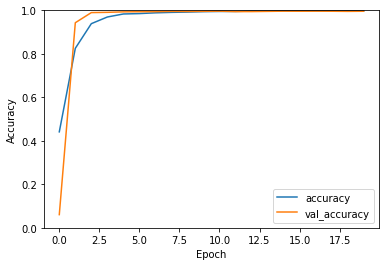

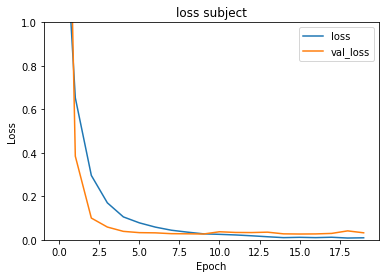

Test Accuracy subject 0.9972513743128436
F1 score: 0.9972514082249188


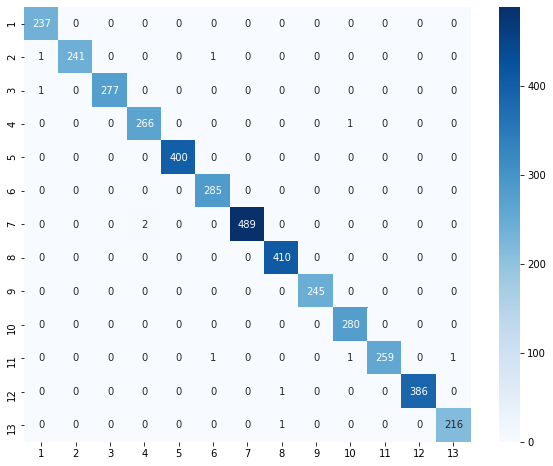

In [ ]:
#ho aumentato un drop-out
history_sub, model_sub =model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub)

In [ ]:
def model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub):
    from tensorflow.keras import regularizers

    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)


    x = Flatten()(x)
    
    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=14, activation='softmax', name='subject')(x)

    model = Model(inputs=x_input, outputs=[output1])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    loss_list = ['categorical_crossentropy']
    model.compile(optimizer=opt,loss=loss_list, metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train_sub, epochs=30,batch_size=33 ,validation_data=(x_val, y_val_sub), verbose=1)

    score = model.evaluate(x_val, y_val_sub, verbose=0)
    print('Validazion loss subject:', score[0])
    print('validation accuracy subject:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title('loss subject')
    plt.show()

    y_predict_sub = model.predict(x_test)


    y_pred = [np.argmax(p) for p in y_predict_sub]
    y_true = [np.argmax(p) for p in y_test_sub]

    accuracy = metrics.accuracy_score(y_true, y_pred)
    print('Test Accuracy subject',accuracy)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    labels = range(1, 14)
    sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels);

    cnn_f1 = metrics.f1_score(y_true, y_pred, average="weighted")
    print("F1 score: {}".format(cnn_f1))

    return history,model

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 64, 32, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 64, 32, 32)        320       
_________________________________________________________________
batch_normalization_65 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 21, 10, 32)        0         
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 21, 10, 32)        0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 21, 10, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 21, 10, 64)        184

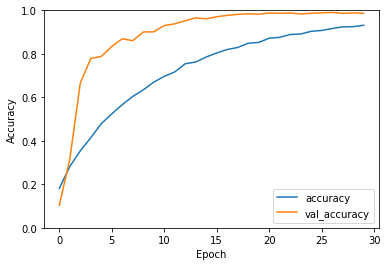

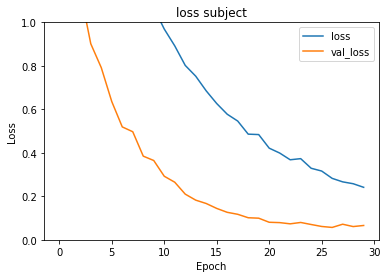

Test Accuracy subject 0.9890043982407037
F1 score: 0.9889959007196636


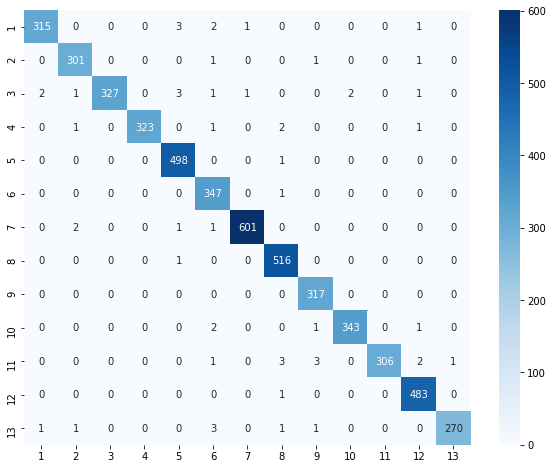

In [ ]:
history_sub_1, model_sub_1=model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub)

In [ ]:
def model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub):
    from tensorflow.keras import regularizers

    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)


    x = Flatten()(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)
    
    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=14, activation='softmax', name='subject')(x)

    model = Model(inputs=x_input, outputs=[output1])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    loss_list = ['categorical_crossentropy']
    model.compile(optimizer=opt,loss=loss_list, metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train_sub, epochs=30,batch_size=33 ,validation_data=(x_val, y_val_sub), verbose=1)

    score = model.evaluate(x_val, y_val_sub, verbose=0)
    print('Validazion loss subject:', score[0])
    print('validation accuracy subject:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title('loss subject')
    plt.show()

    y_predict_sub = model.predict(x_test)


    y_pred = [np.argmax(p) for p in y_predict_sub]
    y_true = [np.argmax(p) for p in y_test_sub]

    accuracy = metrics.accuracy_score(y_true, y_pred)
    print('Test Accuracy subject',accuracy)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    labels = range(1, 14)
    sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels);

    cnn_f1 = metrics.f1_score(y_true, y_pred, average="weighted")
    print("F1 score: {}".format(cnn_f1))

    return history,model

In [ ]:
history_sub_2, model_sub_2=model_subject_experiment_one(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 64, 32, 1)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 64, 32, 32)        320       
_________________________________________________________________
batch_normalization_84 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 21, 10, 32)        0         
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 21, 10, 32)        0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 21, 10, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 21, 10, 64)        184

KeyboardInterrupt: ignored

# Posture classification

In [ ]:
def model_posture_experiment_one(x_train,x_val,x_test,y_train_pos,y_val_pos,y_test_pos):


    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=4, activation='softmax', name='subject')(x)
    model = Model(inputs=x_input, outputs=[output1])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train_pos, epochs=30,batch_size=33, validation_data=(x_val, y_val_pos), verbose=1)

    score = model.evaluate(x_val, y_val_pos, verbose=0)
    print('Validation loss posture:', score[0])
    print('Validation accuracy posture:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title('loss subject')
    plt.show()

    y_predict_pos = model.predict(x_test)

    y_pred = [np.argmax(p) for p in y_predict_pos]
    y_true = [np.argmax(p) for p in y_test_pos]

    accuracy = metrics.accuracy_score(y_true, y_pred)
    print('Test Accuracy Posture',accuracy)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    labels = ['Supine','Right','Left']
    sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels);

    cnn_f1 = metrics.f1_score(y_true, y_pred, average="weighted")
    print("F1 score: {}".format(cnn_f1))
    return history,model

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 64, 32, 1)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 64, 32, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 21, 10, 32)        0         
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 21, 10, 32)        0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 21, 10, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 21, 10, 64)        184

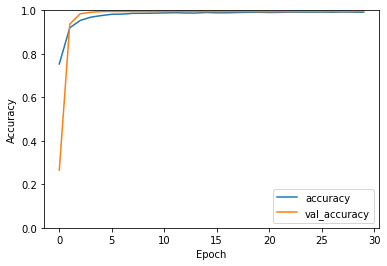

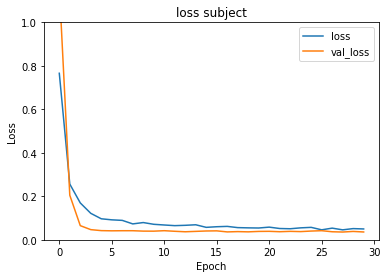

Test Accuracy Posture 0.9936025589764095
F1 score: 0.9936050267995278


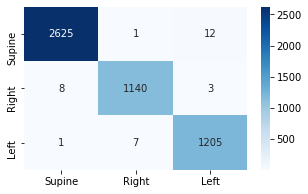

In [ ]:
history_p, model_p = model_posture_experiment_one(x_train,x_val,x_test,y_train_pos,y_val_pos,y_test_pos)

# Joint classification

In [ ]:
def model_joint_subject_posture(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub,y_train_pos,y_val_pos,y_test_pos):
    from tensorflow.keras import regularizers

    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2,)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)


    x = Flatten()(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=14, activation='softmax', name='subject')(x)
    output2 = Dense(units=4, activation='softmax', name='position')(x)

    model = Model(inputs=x_input, outputs=[output1, output2])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    loss_list = ['categorical_crossentropy','categorical_crossentropy']
    model.compile(optimizer=opt, loss=loss_list, metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train,[y_train_sub,y_train_pos], epochs=30,batch_size=33, validation_data=(x_val,[y_val_sub,y_val_pos]), verbose=1)

    score = model.evaluate(x_val, [y_val_sub, y_val_pos], verbose=0)

    print(score)
    print('Validation loss:', score[0])
    print('Validation  accuracy subject:', score[3])
    print('Validation  accuracy posture:', score[4])

    plt.plot(history.history['subject_accuracy'], label='accuracy')
    plt.plot(history.history['val_subject_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['subject_loss'], label='accuracy')
    plt.plot(history.history['val_subject_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['position_accuracy'], label='accuracy')
    plt.plot(history.history['val_position_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['position_loss'], label='accuracy')
    plt.plot(history.history['val_position_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')



    pred = model.predict(x_test)[0]
    y_pred_subject = [np.argmax(p) for p in pred]
    pred = model.predict(x_test)[1]
    y_pred_posture = [np.argmax(p) for p in pred]

    y_true_subject = [np.argmax(p) for p in y_test_sub]

    y_true_posture = [np.argmax(p) for p in y_test_pos]

    accuracy_sub = metrics.accuracy_score(y_true_subject, y_pred_subject)
    print('subject classification accuracy:',accuracy_sub)

    accuracy_posture = metrics.accuracy_score(y_true_posture, y_pred_posture)
    print('posture classification accuracy:',accuracy_posture)


    y_pred = []
    y_true = []
    l = y_pred_subject.shpae[0]

    for i in range(578):
        y_pred.append(str(y_pred_subject[i]) + " " + str(y_pred_posture[i]))
        # print(str(y_pred_subject[i])+ " " +str(y_pred_posture[i]))
        y_true.append(str(y_true_subject[i]) + " " + str(y_true_posture[i]))
        # print(str(y_true_subject[i])+ " " +str(y_true_posture[i]))

    accuracy_joint = metrics.accuracy_score(y_true, y_pred)
    print('joint classification accuracy:',accuracy_joint)

    f1_joint = metrics.f1_score(y_true, y_pred, average="weighted")
    print("joint classification F1 score: {}".format(f1_joint))

    return history,model




Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 64, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 64, 32, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 64, 32, 32)   128         conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 21, 10, 32)   0           batch_normalization_69[0][0]     
___________________________________________________________________________________________

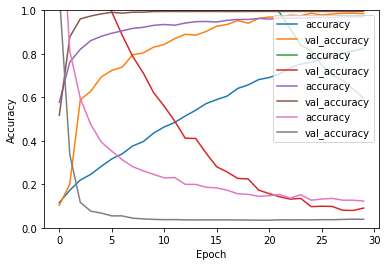

In [ ]:
history_j,model_j= model_joint_subject_posture(x_train,x_val,x_test,y_train_sub, y_val_sub, y_test_sub, y_train_pos,y_val_pos,y_test_pos)

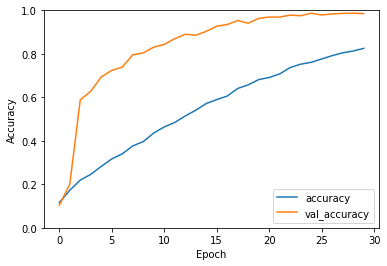

In [ ]:
    plt.plot(history_j.history['subject_accuracy'], label='accuracy')
    plt.plot(history_j.history['val_subject_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

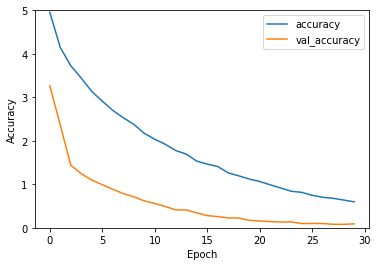

In [ ]:
    plt.plot(history_j.history['subject_loss'], label='accuracy')
    plt.plot(history_j.history['val_subject_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 5])
    plt.legend(loc='upper right')

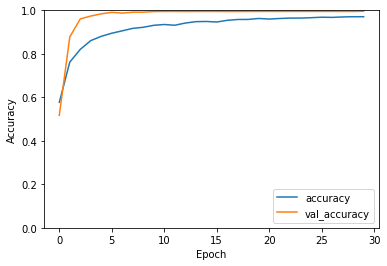

In [ ]:
    plt.plot(history_j.history['position_accuracy'], label='accuracy')
    plt.plot(history_j.history['val_position_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

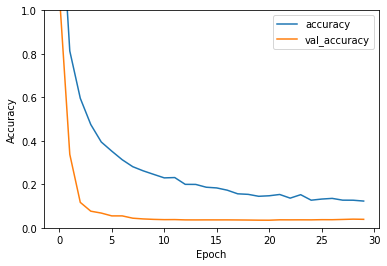

In [ ]:
    plt.plot(history_j.history['position_loss'], label='accuracy')
    plt.plot(history_j.history['val_position_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

In [ ]:
def model_joint_subject_posture(x_train,x_val,x_test,y_train_sub,y_val_sub,y_test_sub,y_train_pos,y_val_pos,y_test_pos):
    from tensorflow.keras import regularizers

    x_input = Input(shape=(64, 32, 1))
    x = Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2,)(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)


    x = Flatten()(x)

    x = Dense(units=256)(x)
    x = Dropout(0.5)(x)

    output1 = Dense(units=14, activation='softmax', name='subject')(x)
    output2 = Dense(units=4, activation='softmax', name='position')(x)

    model = Model(inputs=x_input, outputs=[output1, output2])

    opt = keras.optimizers.Adam(learning_rate=0.00002)
    loss_list = ['categorical_crossentropy','categorical_crossentropy']
    model.compile(optimizer=opt, loss=loss_list, metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train,[y_train_sub,y_train_pos], epochs=30,batch_size=33, validation_data=(x_val,[y_val_sub,y_val_pos]), verbose=1)

    score = model.evaluate(x_val, [y_val_sub, y_val_pos], verbose=0)

    print(score)
    print('Validation loss:', score[0])
    print('Validation  accuracy subject:', score[3])
    print('Validation  accuracy posture:', score[4])

    plt.plot(history.history['subject_accuracy'], label='accuracy')
    plt.plot(history.history['val_subject_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['subject_loss'], label='accuracy')
    plt.plot(history.history['val_subject_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['position_accuracy'], label='accuracy')
    plt.plot(history.history['val_position_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')

    plt.plot(history.history['position_loss'], label='accuracy')
    plt.plot(history.history['val_position_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')



    pred = model.predict(x_test)[0]
    y_pred_subject = [np.argmax(p) for p in pred]
    pred = model.predict(x_test)[1]
    y_pred_posture = [np.argmax(p) for p in pred]

    y_true_subject = [np.argmax(p) for p in y_test_sub]

    y_true_posture = [np.argmax(p) for p in y_test_pos]

    accuracy_sub = metrics.accuracy_score(y_true_subject, y_pred_subject)
    print('subject classification accuracy:',accuracy_sub)

    accuracy_posture = metrics.accuracy_score(y_true_posture, y_pred_posture)
    print('posture classification accuracy:',accuracy_posture)


    y_pred = []
    y_true = []
    l = len(y_pred_subject)

    for i in range(l):
        y_pred.append(str(y_pred_subject[i]) + " " + str(y_pred_posture[i]))
        # print(str(y_pred_subject[i])+ " " +str(y_pred_posture[i]))
        y_true.append(str(y_true_subject[i]) + " " + str(y_true_posture[i]))
        # print(str(y_true_subject[i])+ " " +str(y_true_posture[i]))

    accuracy_joint = metrics.accuracy_score(y_true, y_pred)
    print('joint classification accuracy:',accuracy_joint)

    f1_joint = metrics.f1_score(y_true, y_pred, average="weighted")
    print("joint classification F1 score: {}".format(f1_joint))

    return history,model



Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 64, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 64, 32, 32)   320         input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 64, 32, 32)   128         conv2d_108[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 21, 10, 32)   0           batch_normalization_108[0][0]    
___________________________________________________________________________________________

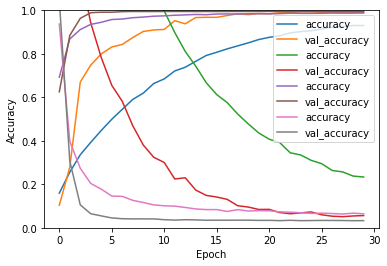

In [ ]:
history_j1,model_j1= model_joint_subject_posture(x_train,x_val,x_test,y_train_sub, y_val_sub, y_test_sub, y_train_pos,y_val_pos,y_test_pos)

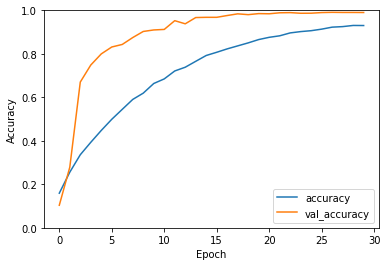

In [ ]:
    plt.plot(history_j1.history['subject_accuracy'], label='accuracy')
    plt.plot(history_j1.history['val_subject_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

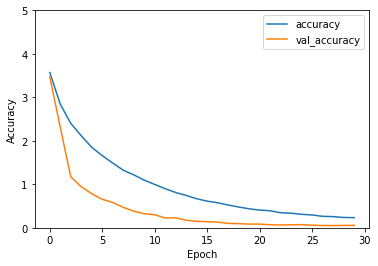

In [ ]:
    plt.plot(history_j1.history['subject_loss'], label='accuracy')
    plt.plot(history_j1.history['val_subject_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 5])
    plt.legend(loc='upper right')

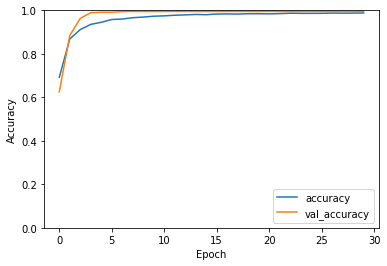

In [ ]:
    plt.plot(history_j1.history['position_accuracy'], label='accuracy')
    plt.plot(history_j1.history['val_position_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

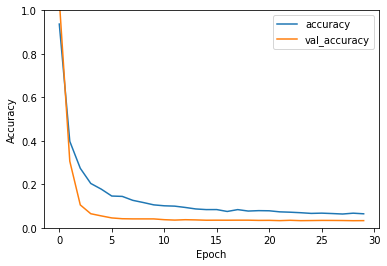

In [ ]:
    plt.plot(history_j1.history['position_loss'], label='accuracy')
    plt.plot(history_j1.history['val_position_loss'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

#CNN



In [ ]:
import keras

Using TensorFlow backend.


In [ ]:
# layers used
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import Softmax
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

In [ ]:

x_input = Input(shape=(32,64,1))
x = Conv2D(32, kernel_size=(3,3),strides = 1, padding='same')(x_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x= LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x= LeakyReLU(alpha=0.2)(x)


x = Conv2D(128, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dense(units=256)(x)
x= Dropout(0.5)(x)

x = Dense(units=256)(x)
x= Dropout(0.5)(x)

output1 = Dense(units=14, activation='softmax', name = 'subject')(x)

model= Model(inputs=x_input,outputs=[output1])

In [ ]:
# Model compile
#sgd = SGD(learning_rate=0.001,momentum=0.8)
opt = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 62, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 62, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 31, 32)        0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 29, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 29, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 14, 64)        

In [ ]:
# fitting the model drop out =0.5
history = model.fit(x_train_n1, y_train_hot_sub, epochs=10, validation_data=(x_valid_n1, y_valid_hot_sub),verbose=1)

Train on 12003 samples, validate on 3001 samples
Epoch 1/10
12003/12003 [==============================] - 74s 6ms/step - loss: 9.2370e-04 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9967
Epoch 2/10
12003/12003 [==============================] - 77s 6ms/step - loss: 6.4326e-04 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9953
Epoch 3/10
12003/12003 [==============================] - 73s 6ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0154 - val_accuracy: 0.9967
Epoch 4/10
12003/12003 [==============================] - 73s 6ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0159 - val_accuracy: 0.9957
Epoch 5/10
12003/12003 [==============================] - 73s 6ms/step - loss: 6.7243e-04 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9967
Epoch 6/10
12003/12003 [==============================] - 73s 6ms/step - loss: 4.5243e-04 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9977
Epoch 7/10
12003/12003 [=============================

In [ ]:
# evaluating the performance on validation set
score = model.evaluate(x_valid_n1, y_valid_hot_sub, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.012061583112545234
Test accuracy: 0.9970009922981262


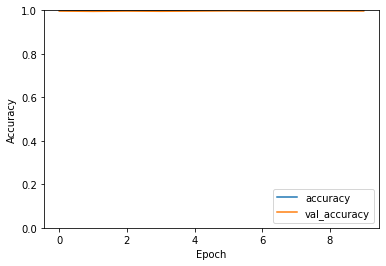

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

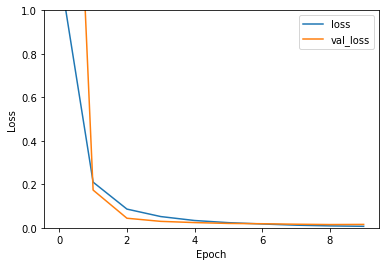

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc='upper right')

In [ ]:
ynew = model.predict_classes(x_test_n1)
ynew

array([12,  5,  7, ...,  6,  3,  7])

In [ ]:
# calculate accuracy on test set
from sklearn import metrics
print(metrics.accuracy_score(y_test, ynew))

0.995752123938031


In [ ]:
# cnn report and analysis
from sklearn.metrics import plot_confusion_matrix 
cnn_mod1 = metrics.f1_score(y_test, ynew, average= "weighted")
cnn_mod = metrics.confusion_matrix(y_test, ynew)
print("cnn")
print("F1 score: {}".format(cnn_mod1))
print("Confusion matrix: \n", cnn_mod)
print('Plotting confusion matrix')

cnn
F1 score: 0.9957541592180081
Confusion matrix: 
 [[237   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 241   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0 276   0   1   0   1   0   0   0   0   0   0]
 [  0   0   0 266   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0 398   0   0   1   0   0   1   0   0]
 [  0   0   0   0   0 284   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0 489   0   0   0   2   0   0]
 [  0   0   0   0   0   0   1 409   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0 243   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0 280   0   0   0]
 [  0   0   0   0   0   1   0   0   1   0 260   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 387   0]
 [  0   0   0   0   0   1   0   1   0   0   0   0 215]]
Plotting confusion matrix


In [ ]:
scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
y_origin_hot = np.eye(14)[y_origin]


for train_index, test_index in cv.split(x_filter):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    #score = model.evaluate(input_test, target_test, verbose=0)
    X_train, X_test, y_train, y_test = x_filter[train_index], x_filter[test_index], y_origin_hot[train_index],y_origin_hot[test_index]
    model.fit(X_train, y_train)
    scores.append(model.evaluate(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train Index:  [ 2003  2004  2005 ... 20021 20022 20023] 

Test Index:  [   0    1    2 ... 2000 2001 2002]
Epoch 1/1
2003/2003 [==============================] - 4s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [2003 2004 2005 ... 4003 4004 4005]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [4006 4007 4008 ... 6006 6007 6008]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [6009 6010 6011 ... 8009 8010 8011]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [ 8012  8013  8014 ... 10011 10012 10013]
Epoch 1/1
2002/2002 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [10014 10015 10016 ... 12013 12014 12015]
Epoch 1/1
2

In [ ]:
print(np.mean(scores))

In [ ]:
#Drop out 0.6
opt = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# summary of the model
model.summary()
# fitting the model
history_1 = model.fit(x_train_n1, y_train_hot, epochs=20, validation_data=(x_valid_n1, y_valid_hot),verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 62, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 62, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 31, 32)        0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 29, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 29, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 14, 64)        

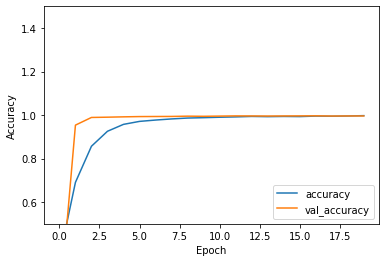

In [ ]:
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.5])
plt.legend(loc='lower right')

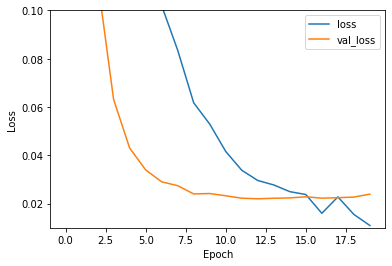

In [ ]:
plt.plot(history_1.history['loss'], label='loss')
plt.plot(history_1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.1])
plt.legend(loc='upper right')

# position Classification


In [ ]:
x_origin= np.array(x_origin).astype(np.int)
y_origin= np.array(P).astype(np.int)

In [ ]:
x_reshape = x_origin.reshape(x_origin.shape[0],32,64,1)

def filter(X):
  result = ndimage.median_filter(X, size=(3,3,3,1))
  return result
x_filter = filter(x_reshape)

In [ ]:
x_filter_origin = x_filter.reshape((20024, 2048))

In [ ]:
# train test val sets


X_train, X_test, y_train, y_test = train_test_split(x_filter_origin,y_origin, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


x_train=np.array(X_train).astype(np.int)
x_valid=np.array(X_val).astype(np.int)
x_test=np.array(X_test).astype(np.int)

y_train=np.array(y_train).astype(np.int)
y_valid=np.array(y_val).astype(np.int)
y_test=np.array(y_test).astype(np.int)

print ("x_train shape: " + str(x_train.shape))
print ("x_test shape: " + str(x_test.shape))
print("x_valid shape: " + str(x_valid.shape))
print ("y_train shape: " + str(y_train.shape))
print ("y_test shape: " + str(y_test.shape))
print("y_valid shape: " + str(y_valid.shape))

x_train shape: (12815, 2048)
x_test shape: (4005, 2048)
x_valid shape: (3204, 2048)
y_train shape: (12815,)
y_test shape: (4005,)
y_valid shape: (3204,)


In [ ]:
# Normalization of the input

x_train_n = x_train/10000
x_test_n = x_test/10000
x_valid_n = x_valid/10000

x_train_n1 = x_train_n.reshape(x_train_n.shape[0],32,64,1)
x_test_n1 = x_test_n.reshape(x_test_n.shape[0],32,64,1)
x_valid_n1 = x_valid_n.reshape(x_valid_n.shape[0],32,64,1)
print("x_train_n1",x_train_n1.shape)
print("x_test_n1",x_test_n1.shape)
print("x_valid_n1",x_valid_n1.shape)

x_train_n1 (12815, 32, 64, 1)
x_test_n1 (4005, 32, 64, 1)
x_valid_n1 (3204, 32, 64, 1)


In [ ]:
# one hot encoding for labels to then use cnn layers
y_train_hot=np.eye(4)[y_train]
print(y_train_hot.shape)
y_test_hot=np.eye(4)[y_test]
print(y_test_hot.shape)
y_valid_hot=np.eye(4)[y_valid]
print(y_valid_hot.shape)

(12815, 4)
(4005, 4)
(3204, 4)


In [ ]:
print(y_valid_hot)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
import keras
# layers used
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [ ]:
# model architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1, 1),input_shape=(32,64,1))) # convolutional, activation layer
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(LeakyReLU(alpha=0.2))


model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1, 1))) # convolutional, activation layer
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3),strides=(1, 1))) # convolutional, activation layer
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1, 1))) # convolutional, activation layer
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
# pooling layer

model.add(Flatten())
model.add(Dense(units=256))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# fitting the model drop out =0.5
history_p = model.fit(x_train_n1, y_train_hot_sub, epochs=20, validation_data=(x_valid_n1, y_valid_hot_sub),verbose=1)

Train on 12003 samples, validate on 3001 samples
Epoch 1/20
12003/12003 [==============================] - 73s 6ms/step - loss: 1.2069 - accuracy: 0.6598 - val_loss: 3.5232 - val_accuracy: 0.0613
Epoch 2/20
12003/12003 [==============================] - 72s 6ms/step - loss: 0.2218 - accuracy: 0.9711 - val_loss: 0.2838 - val_accuracy: 0.9700
Epoch 3/20
12003/12003 [==============================] - 72s 6ms/step - loss: 0.0947 - accuracy: 0.9903 - val_loss: 0.0587 - val_accuracy: 0.9913
Epoch 4/20
12003/12003 [==============================] - 72s 6ms/step - loss: 0.0586 - accuracy: 0.9930 - val_loss: 0.0410 - val_accuracy: 0.9930
Epoch 5/20
12003/12003 [==============================] - 73s 6ms/step - loss: 0.0389 - accuracy: 0.9944 - val_loss: 0.0305 - val_accuracy: 0.9933
Epoch 6/20
12003/12003 [==============================] - 72s 6ms/step - loss: 0.0261 - accuracy: 0.9967 - val_loss: 0.0271 - val_accuracy: 0.9937
Epoch 7/20
12003/12003 [==============================] - 73s 6ms/ste

In [ ]:
# evaluating the performance on validation set
score = model.evaluate(x_valid_n1, y_valid_hot_sub, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.014347058665598158
Test accuracy: 0.9963345527648926


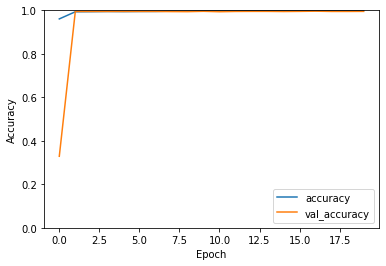

In [ ]:
plt.plot(history_p.history['accuracy'], label='accuracy')
plt.plot(history_p.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

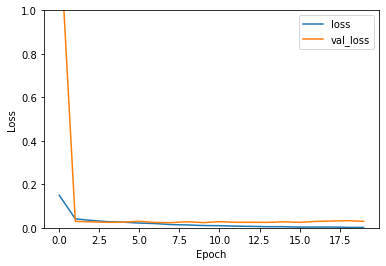

In [ ]:
plt.plot(history_p.history['loss'], label='loss')
plt.plot(history_p.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

In [ ]:
ynew = model.predict_classes(x_test_n1)
ynew

array([1, 3, 1, ..., 1, 1, 1])

In [ ]:
# calculate accuracy on test set
from sklearn import metrics
print(metrics.accuracy_score(y_test, ynew))

0.9930087390761548


In [ ]:
# cnn report and analysis
from sklearn.metrics import plot_confusion_matrix 
cnn_mod1 = metrics.f1_score(y_test, ynew, average= "weighted")
cnn_mod = metrics.confusion_matrix(y_test, ynew)
print("cnn")
print("F1 score: {}".format(cnn_mod1))
print("Confusion matrix: \n", cnn_mod)
print('Plotting confusion matrix')

cnn
F1 score: 0.9929984463626547
Confusion matrix: 
 [[2111    0    2]
 [   7  925    3]
 [   6   10  941]]
Plotting confusion matrix


In [ ]:

y_origin= np.array(P).astype(np.int)
scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
y_origin_hot = np.eye(4)[y_origin]
for train_index, test_index in cv.split(x_filter):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    #score = model.evaluate(input_test, target_test, verbose=0)
    X_train, X_test, y_train, y_test = x_filter[train_index], x_filter[test_index], y_origin_hot[train_index],y_origin_hot[test_index]
    model.fit(X_train, y_train)
    scores.append(model.evaluate(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train Index:  [ 2003  2004  2005 ... 20021 20022 20023] 

Test Index:  [   0    1    2 ... 2000 2001 2002]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [2003 2004 2005 ... 4003 4004 4005]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [4006 4007 4008 ... 6006 6007 6008]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [6009 6010 6011 ... 8009 8010 8011]
Epoch 1/1
2003/2003 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [ 8012  8013  8014 ... 10011 10012 10013]
Epoch 1/1
2002/2002 [==============================] - 3s 2ms/step
Train Index:  [    0     1     2 ... 20021 20022 20023] 

Test Index:  [10014 10015 10016 ... 12013 12014 12015]
Epoch 1/1
2

In [ ]:
sc = []
for i in scores:
  sc.append(i[1])
sc = np.array(sc)
print(np.average(sc))

0.9987018585205079


# Subject + Posture

In [ ]:
x_origin = np.array(Fr).astype(np.int)
y_subject = np.array(S).astype(np.int)
y_position = np.array(P).astype(np.int)


x_reshape = x_origin.reshape(x_origin.shape[0],32,64,1)

def filter(X):
  result = ndimage.median_filter(X, size=(3,3,3,1))
  return result

x_filter = filter(x_reshape)



In [ ]:
print(x_filter.shape)

(20024, 32, 64, 1)


In [ ]:
x_filter_origin = x_filter.reshape((20024, 2048))
#Devo capire per ogni frame quanti valori sono diversi da zero
delete = []
for i in range(20024):
  num =0 
  for j in range(2048):
    if (x_filter_origin[i][j]!=0): 
      num = num+1
  if(num < 500):
    delete.append(i)

for i in delete:
    x_filter_origin= np.delete(x_filter_origin,i,axis = 0)
    y_subject = np.delete(y_subject,i,axis = 0)
    y_position = np.delete(y_position,i,axis = 0)


In [ ]:
X_train, X_test, y_train_sub, y_test_sub, y_train_pos, y_test_pos  = train_test_split(x_filter_origin,y_subject,y_position, random_state=42)

X_train, X_val, y_train_sub, y_val_sub, y_train_pos, y_val_pos = train_test_split(X_train, y_train_sub, y_train_pos,test_size=0.2, random_state=42)

In [ ]:


x_train=np.array(X_train).astype(np.int)
x_valid=np.array(X_val).astype(np.int)
x_test=np.array(X_test).astype(np.int)

y_train_sub = np.array(y_train_sub).astype(np.int)
y_valid_sub = np.array(y_val_sub).astype(np.int)
y_test_sub = np.array(y_test_sub).astype(np.int)

y_train_pos = np.array(y_train_pos).astype(np.int)
y_valid_pos = np.array(y_val_pos).astype(np.int)
y_test_pos = np.array(y_test_pos).astype(np.int)

print ("x_train shape: " + str(x_train.shape))
print ("x_test shape: " + str(x_test.shape))
print("x_valid shape: " + str(x_valid.shape))

print ("y_train_sub shape: " + str(y_train_sub.shape))
print ("y_test_sub shape: " + str(y_test_sub.shape))
print("y_valid _subshape: " + str(y_valid_sub.shape))

print ("y_train_pos shape: " + str(y_train_pos.shape))
print ("y_test_pos shape: " + str(y_test_pos.shape))
print("y_valid _pos shape: " + str(y_valid_pos.shape))

x_train shape: (12003, 2048)
x_test shape: (5002, 2048)
x_valid shape: (3001, 2048)
y_train_sub shape: (12003,)
y_test_sub shape: (5002,)
y_valid _subshape: (3001,)
y_train_pos shape: (12003,)
y_test_pos shape: (5002,)
y_valid _pos shape: (3001,)


In [ ]:
# Normalization of the input

x_train_n = x_train/10000
x_test_n = x_test/10000
x_valid_n = x_valid/10000


In [ ]:
x_train_n1 = x_train_n.reshape(x_train_n.shape[0],32,64,1)
x_test_n1 = x_test_n.reshape(x_test_n.shape[0],32,64,1)
x_valid_n1 = x_valid_n.reshape(x_valid_n.shape[0],32,64,1)
print("x_train_n1",x_train_n1.shape)
print("x_test_n1",x_test_n1.shape)
print("x_valid_n1",x_valid_n1.shape)

x_train_n1 (12003, 32, 64, 1)
x_test_n1 (5002, 32, 64, 1)
x_valid_n1 (3001, 32, 64, 1)


In [ ]:
# one hot encoding for labels to then use cnn layers
y_train_hot_sub=np.eye(14)[y_train_sub]
print(y_train_hot_sub.shape)
y_test_hot_sub=np.eye(14)[y_test_sub]
print(y_test_hot_sub.shape)
y_valid_hot_sub=np.eye(14)[y_valid_sub]
print(y_valid_hot_sub.shape)


y_train_hot_pos=np.eye(4)[y_train_pos]
print(y_train_hot_pos.shape)
y_test_hot_pos=np.eye(4)[y_test_pos]
print(y_test_hot_pos.shape)
y_valid_hot_pos=np.eye(4)[y_valid_pos]
print(y_valid_hot_pos.shape)

(12003, 14)
(5002, 14)
(3001, 14)
(12003, 4)
(5002, 4)
(3001, 4)


In [ ]:
import keras
# layers used
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

In [ ]:

x_input = Input(shape=(32,64,1))
x = Conv2D(32, kernel_size=(3,3),strides = 1, padding='same')(x_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x= LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x= LeakyReLU(alpha=0.2)(x)


x = Conv2D(128, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, kernel_size=(3,3),strides = 1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dense(units=256)(x)
x= Dropout(0.5)(x)

x = Dense(units=256)(x)
x= Dropout(0.5)(x)

output1 = Dense(units=14, activation='softmax', name = 'subject')(x)
output2 = Dense(units=4, activation='softmax', name = 'position')(x)

model= Model(inputs=x_input,outputs=[output1,output2])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# fitting the model drop out =0.5
history_p = model.fit(x_train_n1, [y_train_hot_sub,y_train_hot_pos], epochs=3, validation_data=(x_valid_n1, [y_valid_hot_sub,y_valid_hot_pos]),verbose=1)

Train on 12003 samples, validate on 3001 samples
Epoch 1/20
12003/12003 [==============================] - 186s 15ms/step - loss: 1.5140 - subject_loss: 1.3007 - position_loss: 0.2107 - subject_accuracy: 0.6439 - position_accuracy: 0.9423 - val_loss: 5.2173 - val_subject_loss: 3.7593 - val_position_loss: 1.4581 - val_subject_accuracy: 0.1116 - val_position_accuracy: 0.4508
Epoch 2/20
12003/12003 [==============================] - 185s 15ms/step - loss: 0.3216 - subject_loss: 0.2392 - position_loss: 0.0816 - subject_accuracy: 0.9374 - position_accuracy: 0.9823 - val_loss: 0.1480 - val_subject_loss: 0.1129 - val_position_loss: 0.0349 - val_subject_accuracy: 0.9877 - val_position_accuracy: 0.9947
Epoch 3/20
12003/12003 [==============================] - 185s 15ms/step - loss: 0.1925 - subject_loss: 0.1263 - position_loss: 0.0658 - subject_accuracy: 0.9701 - position_accuracy: 0.9859 - val_loss: 0.0569 - val_subject_loss: 0.0293 - val_position_loss: 0.0275 - val_subject_accuracy: 0.9947 - 

In [ ]:
score = model.evaluate(x_valid_n1, [y_valid_hot_sub, y_valid_hot_pos], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[2])

Test loss: 0.06300457948483747
Test accuracy: 0.03620878607034683


In [ ]:
print(score)

[0.06300457948483747, 0.026649154722690582, 0.03620878607034683, 0.9966678023338318, 0.9966678023338318]


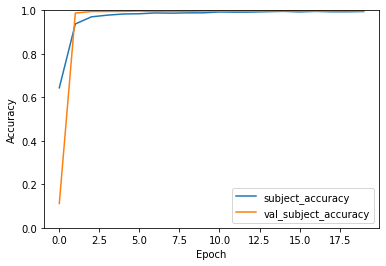

In [ ]:
plt.plot(history_p.history['subject_accuracy'], label='subject_accuracy')
plt.plot(history_p.history['val_subject_accuracy'], label = 'val_subject_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

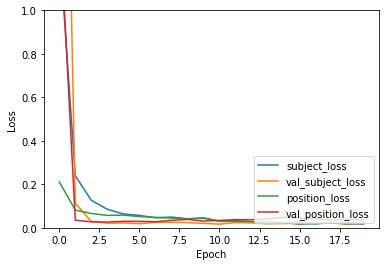

In [ ]:
plt.plot(history_p.history['subject_loss'], label='subject_loss')
plt.plot(history_p.history['val_subject_loss'], label = 'val_subject_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_test_n1)[0]
y_pred = [np.argmax(p) for p in pred]
y_true = [np.argmax(p) for p in y_test_hot_sub]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       322
           2       1.00      0.99      1.00       304
           3       1.00      1.00      1.00       338
           4       1.00      1.00      1.00       328
           5       1.00      1.00      1.00       499
           6       0.99      1.00      1.00       348
           7       1.00      1.00      1.00       605
           8       1.00      1.00      1.00       517
           9       1.00      1.00      1.00       317
          10       1.00      1.00      1.00       347
          11       1.00      0.99      1.00       316
          12       1.00      1.00      1.00       484
          13       1.00      1.00      1.00       277

    accuracy                           1.00      5002
   macro avg       1.00      1.00      1.00      5002
weighted avg       1.00      1.00      1.00      5002



In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_test_n1)[0]
y_pred = [np.argmax(p) for p in pred]
y_true = [np.argmax(p) for p in y_test_hot_sub]

print(classification_report(y_true, y_pred))

In [ ]:
# cnn report and analysis
from sklearn.metrics import plot_confusion_matrix 
cnn_mod1 = metrics.f1_score(y_test_hot_sub, pred[0], average= "weighted")
cnn_mod = metrics.confusion_matrix(y_test_hot_sub, pred[0])
print("cnn")
print("F1 score: {}".format(cnn_mod1))
print("Confusion matrix: \n", cnn_mod)
print('Plotting confusion matrix')